# Margin density drift detection (MD3) on wine quality dataset

## Overview

The margin density drift detector (MD3) ([Sethi and  Kantardzic, 2015](https://www.sciencedirect.com/science/article/pii/S1877050915017871)) quantifies the percentage of predictions made by a probabilistic binary classifier at the decision boundary (as defined by a margin).  This quantity is known as the margin density.  The margin density is compared to an allowable margin density range.  Drift is detected if the calculated margin density for a given batch falls outside of the specified margin density range.  Care should be taken when setting the margin density range.  This can be guided, for example, by calculating the margin density mean and variance on out-of-fold instances when performing k-fold cross-validation, or on data batches from an additional holdout set that are characteristically similar to the data on which the binary classifier was trained.  Low and high margin densities relative to the allowable density range can be indicative of virtual drift, concept drift and/or general changes in model performance.

Many alternative drift detection methods focus on tracking changes in the distribution of the data inputs.  These approaches can be prone to generating false positives as they implicitly give equal importance to all features, even those that are of very little importance to the classifier.  The utility of the MD3 approach is that it uses the change in the percentage of samples contained within a classifier's decision boundary (i.e., margin) as a proxy for measuring changes in the probability distribution of the labels given the data inputs, _without actually requiring any labeled data_.  This approach tends to be more robust against false positives as the classifier accounts for differences in feature importances, giving little emphasis to features that do not affect classification performance.

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

from alibi_detect.cd import ClassifierDrift
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

(494021, 18) (494021,)


For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

(400000, 18) (400000,)
0.0% outliers


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [ ]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be flagged as drift. We also split the corrupted data by corruption type:

In [ ]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

In [6]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

In [ ]:
i = 6

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift

We use a simple classification model and try to distinguish between the reference data and the corrupted test sets. Initially we'll use an accuracy threshold set at $0.55$, use $75$% of the shuffled reference and test data for training and evaluate the detector on the remaining $25$%. We only train for 1 epoch.

In [9]:
tf.random.set_seed(0)

model = tf.keras.Sequential(
  [
      Input(shape=(32, 32, 3)),
      Conv2D(8, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(16, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(2, activation='softmax')
  ]
)

cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, train_size=.75, epochs=1)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

New threshold: 1.7367815971374498


In [ ]:
preds_h0 = cd.predict(X_h0)

labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

As expected, no drift occurred. The accuracy of the classifier is close to random and below the threshold:

In [ ]:
print(f"accuracy: {preds_h0['data']['accuracy']} -- threshold: {preds_h0['data']['threshold']}")

Let's now check the predictions on the corrupted data:

In [ ]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"Accuracy: {preds['data']['accuracy']}")
    print('')

The classifier could easily distinguish the corrupted from the reference data.

### Use all the available data

So far we've only used $25$% of the data to detect the drift since $75$% is used for training purposes. At the cost of additional training time we can however leverage all the data via stratified cross-validation. We just need to set the number of folds and keep everything else the same. So for each test set `n_folds` models are trained, and the out-of-fold predictions combined for the final drift metric (in this case the accuracy):

In [ ]:
cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, n_folds=5, epochs=1)

In [ ]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"Accuracy: {preds['data']['accuracy']}")
    print('')

F1 score: 0.9754


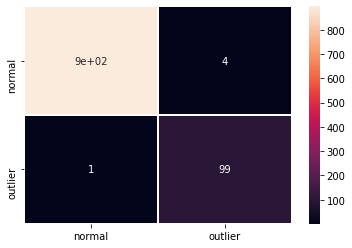

In [13]:
preds_h0 = cd.predict(X_h0)
print(f"Drift? {labels[preds_h0['data']['is_drift']]}")
print(f"Accuracy: {preds_h0['data']['accuracy']}")

### Customize the drift metric

The drift metric can be adjusted which is very helpful in cases when there is for instance class imbalance as the test dataset sizes can vary by batch. Any function taking `y_true` and `y_pred` als input can be used as drift metric. In the following we'll use the $F1$-score as an illustration:

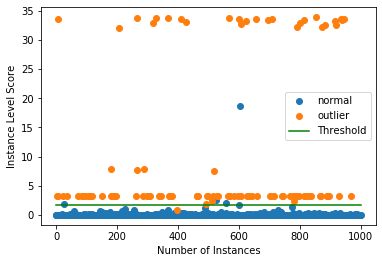

In [14]:
from sklearn.metrics import f1_score

def f1_adj(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return f1_score(y_true, np.round(y_pred))  # model returns soft predictions, not class labels

In [ ]:
cd = ClassifierDrift(threshold=.55, model=model, X_ref=X_ref, n_folds=5, epochs=1, metric_fn=f1_adj)

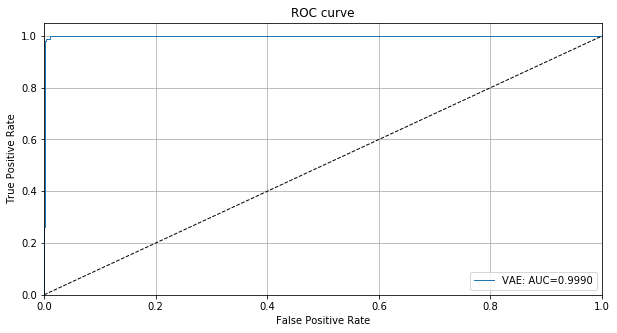

In [15]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x)
    print(f'Corruption type: {c}')
    print(f"Drift? {labels[preds['data']['is_drift']]}")
    print(f"F1 score: {preds['data']['f1_adj']}")
    print('')

In [ ]:
preds_h0 = cd.predict(X_h0)

print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))
print(f"F1 score: {preds_h0['data']['f1_adj']}")